In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv("D:\\usuarios\\filipe.acoliveira\\Downloads\\household_power_consumption.txt", delimiter=';', nrows=300000)
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (300000, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [3]:
df.dtypes
df.shape
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
299995,13/7/2007,01:19:00,0.328,0.222,240.670,1.600,0.000,0.000,0.0000
299996,13/7/2007,01:20:00,0.328,0.220,240.340,1.600,0.000,0.000,0.0000
299997,13/7/2007,01:21:00,0.326,0.224,240.820,1.600,0.000,0.000,0.0000
299998,13/7/2007,01:22:00,0.324,0.222,240.740,1.600,0.000,0.000,0.0000
299999,13/7/2007,01:23:00,0.324,0.226,241.240,1.600,0.000,0.000,0.0000


In [4]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [5]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['date_time']=pd.to_datetime(df['date_time']) 


In [6]:

df_na = df.copy()
df = df.dropna(subset=['Global_active_power'])


In [7]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,16/12/2006,17:24:00,4.2160,0.418,234.840,18.400,0.000,1.000,17.0000,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.3600,0.436,233.630,23.000,0.000,1.000,16.0000,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.3740,0.498,233.290,23.000,0.000,2.000,17.0000,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.3880,0.502,233.740,23.000,0.000,1.000,17.0000,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.6660,0.528,235.680,15.800,0.000,1.000,17.0000,2006-12-16 17:28:00


In [11]:
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df['hour'] = df['date_time'].apply(lambda x: x.hour)

In [12]:
df.head()

,date_time,Global_active_power,year,quarter,month,day,hour
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,17
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,17
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,17
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,17
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,17


In [13]:
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df = df.iloc[:200000, :]

In [14]:
df.head()
df.tail()


,date_time,Global_active_power,year,quarter,month,day
199995,2007-06-01 04:52:00,0.2600,2007,2,6,1
199996,2007-06-01 04:53:00,0.2440,2007,2,6,1
199997,2007-06-01 04:54:00,0.2440,2007,2,6,1
199998,2007-06-01 04:55:00,0.2440,2007,2,6,1
199999,2007-06-01 04:56:00,0.2440,2007,2,6,1


In [15]:
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)


In [16]:
df.head()

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0


In [17]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.head()

,Global_active_power
date_time,
2006-12-16 17:24:00,4.2160
2006-12-16 17:25:00,5.3600
2006-12-16 17:26:00,5.3740
2006-12-16 17:27:00,5.3880
2006-12-16 17:28:00,3.6660


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


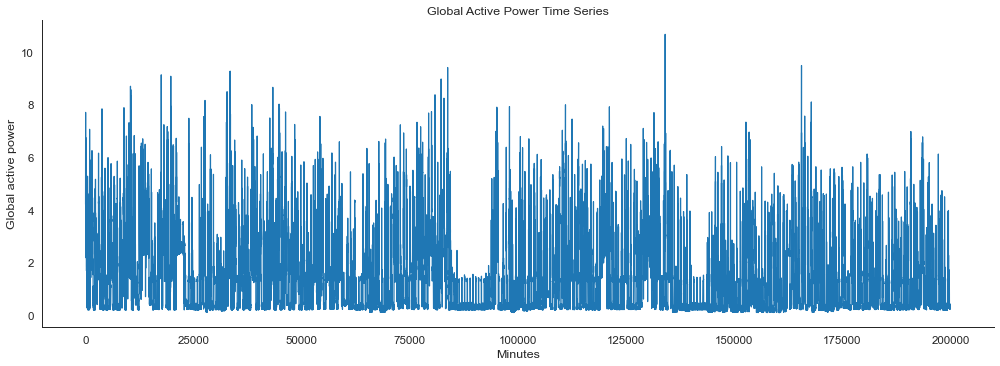

In [26]:
# df1.plot(marker='o', linestyle='', alpha=0.1, figsize=(12,5))
plt.figure(1, figsize=(14,5))
plt.plot(range(len(df1.iloc[:, 0])), df1['Global_active_power'])
plt.ylabel('Global active power')
plt.xlabel('Minutes')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

# **LSTM Model**

In [53]:
from sklearn.preprocessing import MinMaxScaler

dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
# print(dataset)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
        
        # s = "X append indexes: "
        # for j in range(i, i+look_back):
        #     s += str(j) + " "
        # print(s)
        # print("Y append indexes: " + str(i+look_back))
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# print(X_train)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# print(X_train)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [54]:
X_train.shape

(159969, 1, 30)

In [56]:
model = Sequential()
model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=100, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/10
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0018
Epoch 2/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 5/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 6/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 7/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 8/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 9/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 10/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0011
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM) 

In [57]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


1250/1250 [==============================] - 1s 695us/step


In [35]:
Y_test.shape
test_predict.shape

(39969, 1)

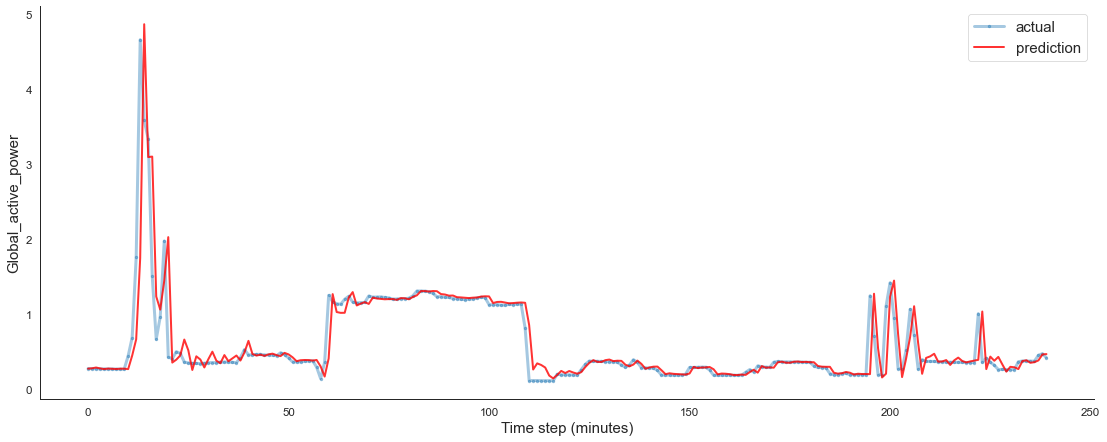

In [61]:
init = 600
time_steps = init + 240

aa=[x for x in range(time_steps - init)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test[0, init:time_steps], marker='.', label="actual", linewidth=3, alpha=0.4)
plt.plot(aa, test_predict[init:time_steps,0], 'r', label="prediction", linewidth=2, alpha=0.8)
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step (minutes)', size=15)
plt.legend(fontsize=15)
plt.show();

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.13890655419015413
Train Root Mean Squared Error: 0.3388456131419793
Test Mean Absolute Error: 0.11814217882674549
Test Root Mean Squared Error: 0.30205819145564167
